In [19]:
"""
Created on Mon Aug 12 18:21:44 2024

@author: Junwoo
"""
# importing required libraries 
from torchcpd import RigidRegistration
from torchcpd import AffineRegistration
from torchcpd import DeformableRegistration
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
import numpy as np 

In [29]:
# Load the data

arr = np.loadtxt("N:/Data/Heart HH16-17/cropped C1-Round 1 Heart 4 20x MYH15 TBX18 TIE1 Face 1-1_centroids_coord.csv", 
                 delimiter=",", dtype=str)
arr = arr.astype(np.float32)  # Convert directly to float32 numpy array

# # Use inline backend instead of widget
# %matplotlib inline

# # Create a new figure and 3D axes
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Extract x, y, z coordinates
# xs = arr[:, 0]
# ys = arr[:, 1]
# zs = arr[:, 2]

# # Create the 3D scatter plot
# scatter = ax.scatter(xs, ys, zs, c=zs, cmap='viridis', marker='o')

# # Add labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Centroids Plot')

# # Add a color bar
# plt.colorbar(scatter)

# # Enable grid
# ax.grid(True)

# # Show the plot
# plt.show()

In [30]:
arr

array([[331.992,   2.064,   5.777],
       [397.875,   2.941,   4.376],
       [520.061,   2.2  ,   7.123],
       ...,
       [482.576, 437.387, 199.324],
       [504.663, 444.332, 204.892],
       [491.778, 433.957, 205.579]], dtype=float32)

In [32]:
import torch
arr = torch.tensor(arr, dtype=torch.float32)


In [33]:
arr

tensor([[331.9920,   2.0640,   5.7770],
        [397.8750,   2.9410,   4.3760],
        [520.0610,   2.2000,   7.1230],
        ...,
        [482.5760, 437.3870, 199.3240],
        [504.6630, 444.3320, 204.8920],
        [491.7780, 433.9570, 205.5790]])

In [34]:
# Convert tensors back to numpy for registration
arr_np = arr.numpy()

In [35]:
translation_np = np.array([0, 1000, 0], dtype=np.float32)

# Create rotation angles in numpy
thetax = (30/180)*np.pi
thetay = (30/180)*np.pi
thetaz = (30/180)*np.pi

# Create rotation matrices with numpy
rotx = np.array([
    [1, 0, 0],
    [0, np.cos(thetax), -np.sin(thetax)],
    [0, np.sin(thetax), np.cos(thetax)],
], dtype=np.float32)

roty = np.array([
    [np.cos(thetay), 0, np.sin(thetay)],
    [0, 1, 0],
    [-np.sin(thetay), 0, np.cos(thetay)],
], dtype=np.float32)

rotz = np.array([
    [np.cos(thetaz), -np.sin(thetaz), 0],
    [np.sin(thetaz), np.cos(thetaz), 0],
    [0, 0, 1],
], dtype=np.float32)

# Apply rotations and translation using numpy
rot = np.dot(np.dot(rotx, roty), rotz)
rotated = np.dot(arr_np, rot.T)
source = rotated + translation_np

In [36]:
# Create registration object with numpy arrays
reg = RigidRegistration(
    X=arr_np,
    Y=source,
    max_iterations=100,
    tolerance=1e-5,
    w=0.0,
)


In [46]:
try:
    # Run registration
    TY, (s_reg, R_reg, t_reg) = reg.register()
    
    # Move tensors to CPU and convert to numpy for printing/calculation
    s_reg_np = s_reg.cpu().numpy()
    R_reg_np = R_reg.cpu().numpy()
    t_reg_np = t_reg.cpu().numpy()
    TY_np = TY.cpu().numpy()
    
    # Print registration results
    print("Scale:", s_reg_np)
    print("Rotation matrix:\n", R_reg_np)
    print("Translation vector:", t_reg_np)
    
    # Calculate registration error using numpy arrays
    error = np.mean(np.linalg.norm(TY_np - arr_np, axis=1))
    print("Average registration error:", error)
    
    registrationRMS = np.sqrt(np.mean((TY_np - arr_np)**2))
    print("RMS of registraion:", registrationRMS)

    # Optional: Save the registration parameters
    # np.save('registration_params.npz', {
    #     'scale': s_reg_np,
    #     'rotation': R_reg_np,
    #     'translation': t_reg_np
    # })

except Exception as e:
    print("Registration error:", str(e))
    print("X array info:", arr_np.dtype, arr_np.shape)
    print("Y array info:", source.dtype, source.shape)

Scale: 0.99999994
Rotation matrix:
 [[ 0.7500002  -0.43301275  0.50000006]
 [ 0.6495189   0.62499994 -0.43301284]
 [-0.12500009  0.6495191   0.7500003 ]]
Translation vector: [-649.5188  -624.9999   433.01282]
Average registration error: 9.949089e-05
RMS of registraion: 6.531343e-05


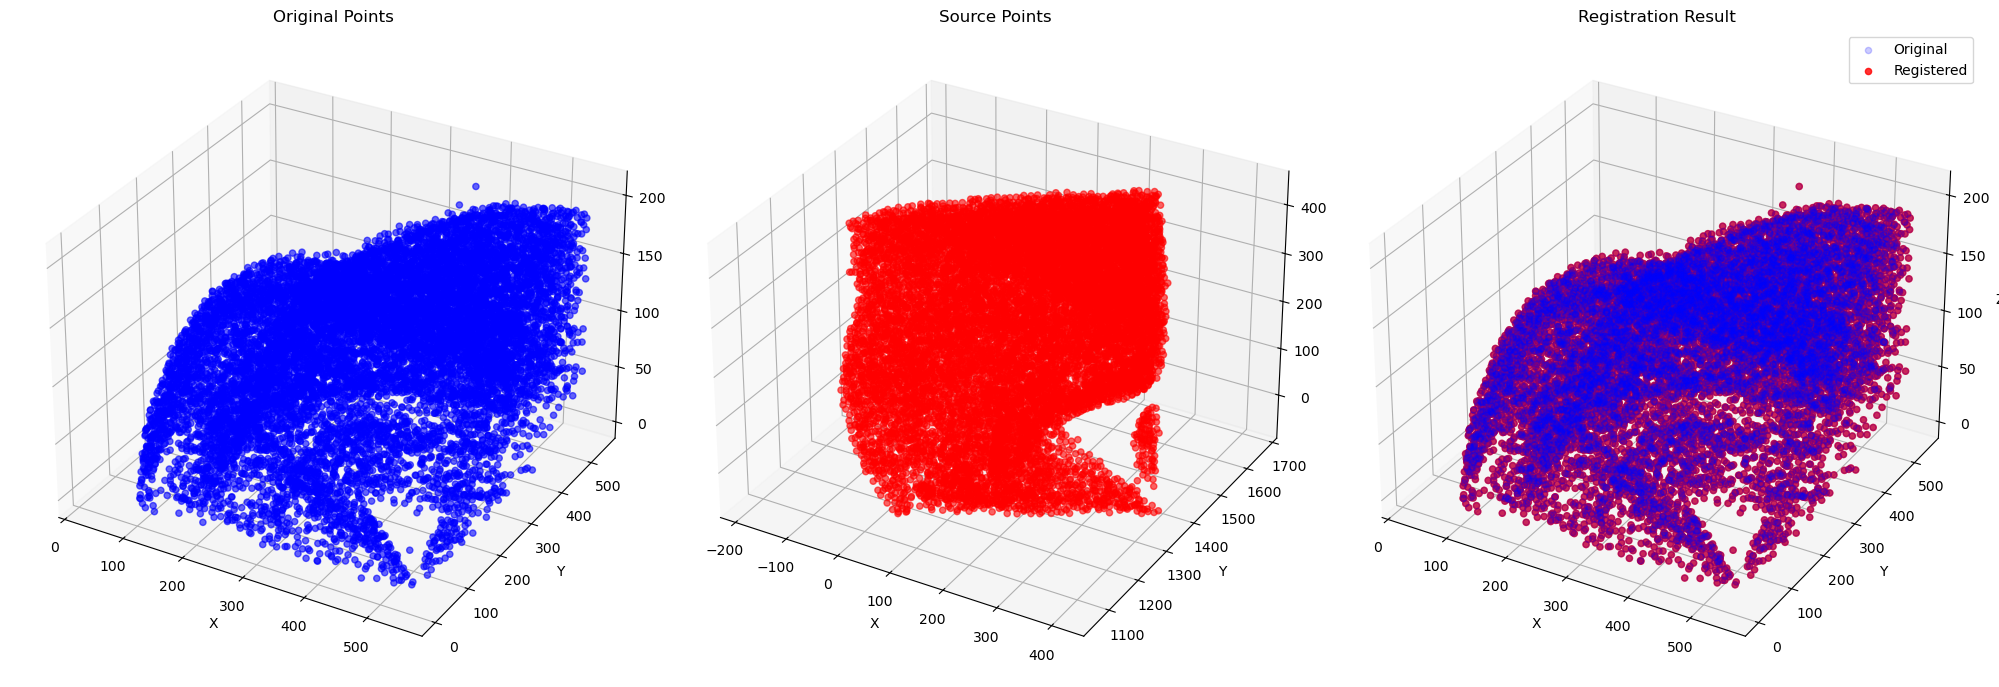

In [51]:
# Enable inline plotting
%matplotlib inline

# Create a new figure and 3D axes
fig = plt.figure(figsize=(20, 10))

# Create three subplots for: original points, transformed points, and overlay
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# Plot 1: Original points (arr_np)
scatter1 = ax1.scatter(arr_np[:, 0], arr_np[:, 1], arr_np[:, 2], 
                      c='blue', marker='o', label='Original', alpha=0.6)
ax1.set_title('Original Points')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.grid(True)


# Plot 2: Source points (points to be registered)
scatter2 = ax2.scatter(source[:, 0], source[:, 1], source[:, 2], 
                      c='red', marker='o', label='Source', alpha=0.6)
ax2.set_title('Source Points')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.grid(True)

# Plot 3: Overlay of original and registered points
scatter3_1 = ax3.scatter(arr_np[:, 0], arr_np[:, 1], arr_np[:, 2], 
                        c='blue', marker='o', label='Original', alpha=0.2)
scatter3_2 = ax3.scatter(TY_np[:, 0], TY_np[:, 1], TY_np[:, 2], 
                        c='red', marker='o', label='Registered', alpha=0.8)
ax3.set_title('Registration Result')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.grid(True)
ax3.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# # Optional: Create a second figure to show the registration error distribution
# plt.figure(figsize=(8, 6))
# distances = np.linalg.norm(TY_np - arr_np, axis=1)
# plt.hist(distances, bins=50, color='blue', alpha=0.7)
# plt.xlabel('Point-to-point Distance')
# plt.ylabel('Frequency')
# plt.title('Distribution of Registration Errors')
# plt.grid(True)
# plt.show()

# # Print some statistics about the registration error
# print(f"Min error: {np.min(distances):.6f}")
# print(f"Max error: {np.max(distances):.6f}")
# print(f"Mean error: {np.mean(distances):.6f}")
# print(f"Median error: {np.median(distances):.6f}")
# print(f"Std error: {np.std(distances):.6f}")


In [35]:
# create a small rotation to apply to the target for testing the registration
thetax = (10/180)*np.pi
thetay = (10/180)*np.pi
thetaz = (10/180)*np.pi

rotx = np.array([
 [1, 0, 0],
 [0, np.cos(thetax), -np.sin(thetax)],
 [0, np.sin(thetax), np.cos(thetax)]
])

roty = np.array([
 [np.cos(thetay), 0, np.sin(thetay)],
 [0, 1, 0],
 [-np.sin(thetay), 0, np.cos(thetay)],
])

rotz = np.array([
 [np.cos(thetaz), -np.sin(thetaz), 0],
 [np.sin(thetaz), np.cos(thetaz), 0],
 [0, 0, 1]
])

scale = np.array([
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 2]
])

scaled = scale.dot(arr.T).T

# apply rotation through dot products
rot = np.dot(np.dot(rotx, roty),rotz)
rotated = rot.dot(scaled.T).T

# create a translation matrix with random displacement to apply to the target for testing the registration
translation = np.random.normal(0, 10, size=rotated.shape)
#translation = translation + [0, 1000, 0]

# create a fake source by adding a translation to the target.
# in a real use, you would load the source points from a file or other source.
# the only requirement is that this array also be 2-dimensional and that the
# second dimension be the same length as the second dimension of the target array.
source = rotated + translation

# create a RigidRegistration object
reg = RigidRegistration(X=arr, Y=source)
# run the registration & collect the results
TY, (s_reg, R_reg, t_reg) = reg.register()

# TY is the transformed source points
# the values in () are the registration parameters.
# In this case of rigid registration they are:
#     s_reg the scale of the registration
#     R_reg the rotation matrix of the registration
#     t_reg the translation of the registration
registrationRMS = np.sqrt(np.mean((TY-arr)**2))
print('RMS of registraion:', registrationRMS)

RMS of registraion: 151.22653201587596


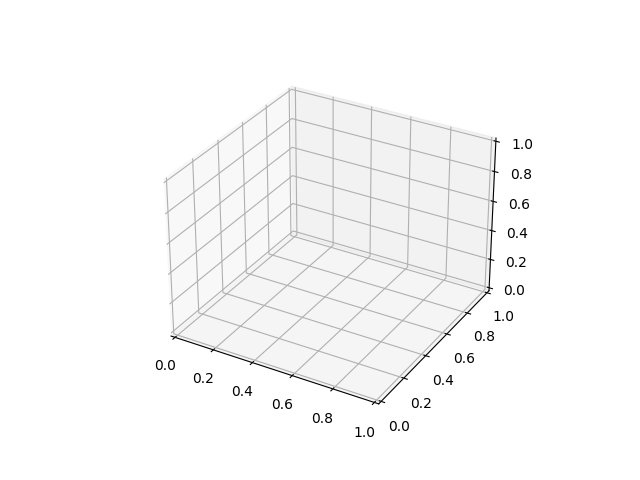

In [36]:
# creating figure 
figg3 = plt.figure() 
ax3 = figg3.add_subplot(111, projection='3d') 

In [37]:
ax3.clear()
plot_geeks = ax3.scatter(xs, ys, zs, marker='o', c='r') 
plot_geeks = ax3.scatter(source[:,[0]], source[:,[1]], source[:,[2]], marker='o', facecolors='none', edgecolors='b', linewidths = 2) 

# setting title and labels 
ax3.set_title("Small rotation, local displacements and scaling") 
ax3.set_xlabel('x-axis') 
ax3.set_ylabel('y-axis') 
ax3.set_zlabel('z-axis') 

# setting limits to each axis
ax3.set_xlim(-1100,1100)
ax3.set_ylim(-100,2100)
ax3.set_zlim(-1100,1100)

(-1100.0, 1100.0)

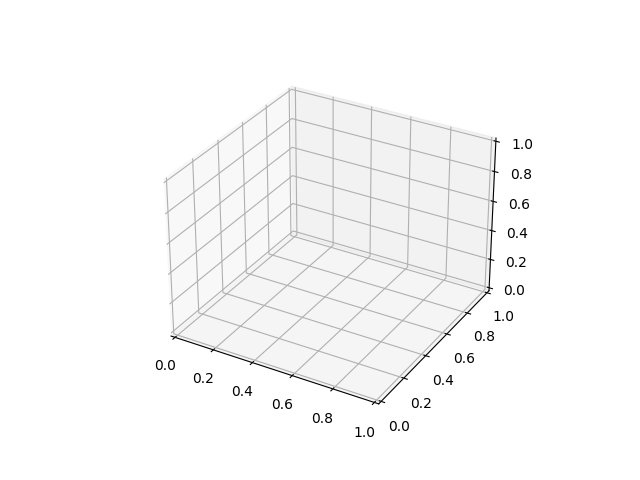

In [38]:
# creating figure 
figg4 = plt.figure() 
ax4 = figg4.add_subplot(111, projection='3d') 

In [39]:
ax4.clear()
plot_geeks = ax4.scatter(xs, ys, zs, marker='o', c='r') 
plot_geeks = ax4.scatter(TY[:,0], TY[:,[1]], TY[:,[2]], marker='o', facecolors='none', edgecolors='b', linewidths = 2)
# setting title and labels 
ax4.set_title("Rigid registraion result 2") 
ax4.set_xlabel('x-axis') 
ax4.set_ylabel('y-axis') 
ax4.set_zlabel('z-axis') 

Text(0.5, 0, 'z-axis')

In [40]:
# Run Affine registraion
# create a AffineRegistration object
reg = AffineRegistration(**{'X': arr, 'Y': source})
# run the registration & collect the results
TYAffine, Y = reg.register()

# TY is the transformed source points
# the values in () are the registration parameters.
# In this case of rigid registration they are:
#     s_reg the scale of the registration
#     R_reg the rotation matrix of the registration
#     t_reg the translation of the registration
registrationRMS = np.sqrt(np.mean((TYAffine-arr)**2))
print('RMS of registraion:', registrationRMS)

RMS of registraion: 7.016440814207382


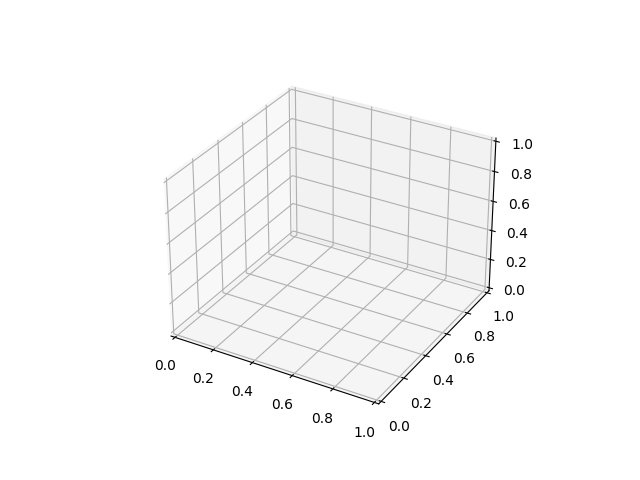

In [41]:
# creating figure 
figg5 = plt.figure() 
ax5 = figg5.add_subplot(111, projection='3d') 

In [42]:
ax5.clear()
plot_geeks = ax5.scatter(xs, ys, zs, marker='o', c='r') 
plot_geeks = ax5.scatter(TYAffine[:,0], TYAffine[:,[1]], TYAffine[:,[2]], marker='o', facecolors='none', edgecolors='b', linewidths = 2)
# setting title and labels 
ax5.set_title("Affine registration result") 
ax5.set_xlabel('x-axis') 
ax5.set_ylabel('y-axis') 
ax5.set_zlabel('z-axis') 

Text(0.5, 0, 'z-axis')

In [43]:
# Run Deformable registraion
# create a DeformableRegistration object
reg = DeformableRegistration(**{'X': arr, 'Y': source, 'low_rank': True})
# run the registration & collect the results
TYdeformed, Y = reg.register()

# TY is the transformed source points
# the values in () are the registration parameters.
# In this case of rigid registration they are:
#     s_reg the scale of the registration
#     R_reg the rotation matrix of the registration
#     t_reg the translation of the registration
registrationRMS = np.sqrt(np.mean((TYdeformed-arr)**2))
print('RMS of registraion:', registrationRMS)

RMS of registraion: 407.48512335727


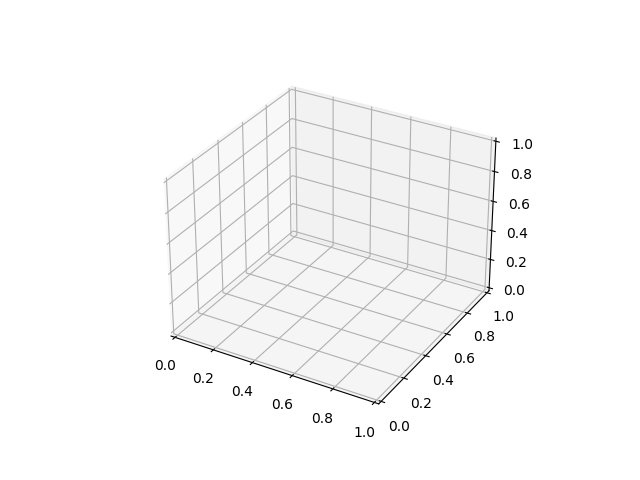

In [44]:
# creating figure 
figg6 = plt.figure() 
ax6 = figg6.add_subplot(111, projection='3d') 


In [45]:
ax6.clear()
plot_geeks = ax6.scatter(xs, ys, zs, marker='o', c='r') 
plot_geeks = ax6.scatter(TYdeformed[:,0], TYdeformed[:,[1]], TYdeformed[:,[2]], marker='o', facecolors='none', edgecolors='b', linewidths = 2)
# setting title and labels 
ax6.set_title("Deformable registration result") 
ax6.set_xlabel('x-axis') 
ax6.set_ylabel('y-axis') 
ax6.set_zlabel('z-axis') 

Text(0.5, 0, 'z-axis')

In [50]:
# Run Deformable registraion
# create a DeformableRegistration object
reg = DeformableRegistration(**{'X': arr, 'Y': TYAffine})
# run the registration & collect the results
TYdeformed, Y = reg.register()

# TY is the transformed source points
# the values in () are the registration parameters.
# In this case of rigid registration they are:
#     s_reg the scale of the registration
#     R_reg the rotation matrix of the registration
#     t_reg the translation of the registration
registrationRMS = np.sqrt(np.mean((TYdeformed-arr)**2))
print('RMS of registraion:', registrationRMS)

RMS of registraion: 6.967976922780802


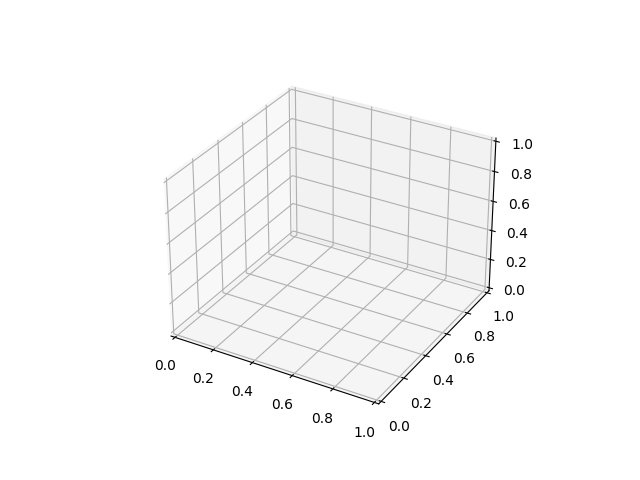

In [47]:
# creating figure 
figg7 = plt.figure() 
ax7 = figg7.add_subplot(111, projection='3d')

In [48]:
ax7.clear()
plot_geeks = ax7.scatter(xs, ys, zs, marker='o', c='r') 
plot_geeks = ax7.scatter(TYdeformed[:,0], TYdeformed[:,[1]], TYdeformed[:,[2]], marker='o', facecolors='none', edgecolors='b', linewidths = 2)
# setting title and labels 
ax7.set_title("Deformable registration result") 
ax7.set_xlabel('x-axis') 
ax7.set_ylabel('y-axis') 
ax7.set_zlabel('z-axis') 

Text(0.5, 0, 'z-axis')